Part 1 : Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Part 2 : loading data

In [2]:
# Dossier contenant les spectrogrammes
data_dir = "../Spectrograms"
img_size = (128, 128)  # Taille standardisée

X = []
y = []

# Lecture des images et des labels
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".png"):
                img_path = os.path.join(label_path, file)
                img = load_img(img_path, target_size=img_size, color_mode="rgb")
                img_array = img_to_array(img) / 255.0  # Normalisation
                X.append(img_array)
                y.append(label)

X = np.array(X)
y = np.array(y)

print("Nombre d'images :", X.shape[0])
print("Taille des images :", X.shape[1:])


Nombre d'images : 3131
Taille des images : (128, 128, 3)


Partie 3 : Préparation des labels

In [3]:
# encoder les labels 
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# split train / test  
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# get classe older : 
class_names = le.classes_

Part 4 : Create CNN model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Activation

model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.3),

    Flatten(),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')
])


partie pour tensorboard 

In [14]:
# Préparation de TensorBoard
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)

Partie 5 : Compilation et entraînement

In [22]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# application de l'augmentation uniquement sur X_train
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# compilation du modèle 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle avec les données augmentées
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, tensorboard_callback]
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 768ms/step - accuracy: 0.8070 - loss: 0.5766 - val_accuracy: 0.7783 - val_loss: 0.8718
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 704ms/step - accuracy: 0.8141 - loss: 0.5455 - val_accuracy: 0.8038 - val_loss: 0.7547
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 61s 778ms/step - accuracy: 0.8258 - loss: 0.4980 - val_accuracy: 0.7671 - val_loss: 0.8727
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 924ms/step - accuracy: 0.7986 - loss: 0.5645 - val_accuracy: 0.7879 - val_loss: 0.6683
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 690ms/step - accuracy: 0.8283 - loss: 0.5101 - val_accuracy: 0.7735 - val_loss: 0.7985
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 759ms/step - accuracy: 0.8266 - loss: 0.4867 - val_accuracy: 0.6762 - val_loss: 1.1452
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 836ms/step - accuracy: 0.8192 - loss: 0.5350 - val_accuracy: 0.8214 - val_loss: 0.6286
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 787ms/step - accuracy: 0.8247 - loss: 0.5240 - val_accu

Partie 6 : Sauvegarde du modèle

In [24]:
# Sauvegarde du modèle
model.save("../ia_model/saved_model/bird_classifier.h5")

# Sauvegarde des classes
with open("../ia_model/saved_model/classes.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")


barre 

In [28]:
%pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


matrice de confusion

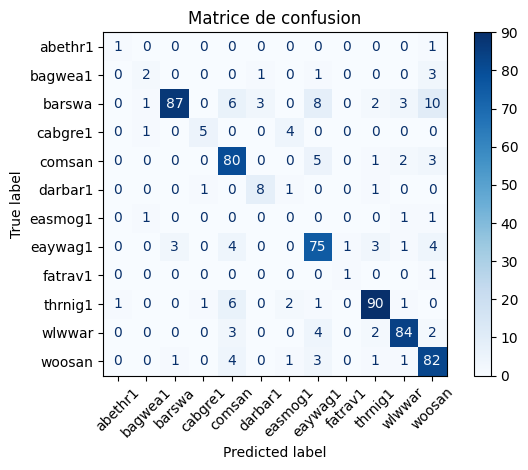

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true : vraies classes
# y_pred : classes prédites
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matrice de confusion")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()



In [36]:
# Prédiction sur le jeu de test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Vraies étiquettes (désencodées)
y_true = np.argmax(y_test, axis=1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
